# Hidden Markov Models

In [56]:
# import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 

import operator
from copy import copy
from scipy.special import softmax

from hmmlearn import hmm

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [2]:
#load the labelled data

data = pd.read_csv('./labelled_df.csv')
print(data.shape)

(2476065, 42)


In [3]:
# Check that none of the features to be used contain NaN values
cols_with_nan = data.isna().any()
cols_with_nan['encrypted_user_no'] = True
cols_with_nan['insert_date'] = False
nan_cols_df = data.loc[:, cols_with_nan]
rows_with_nan_in_cols = nan_cols_df[nan_cols_df.isna().any(axis=1)]
print(rows_with_nan_in_cols)

Empty DataFrame
Columns: [encrypted_user_no]
Index: []


In [4]:
data.isna().sum()

betTimestamp                               0
odds_units                                 0
stake_gbp                                  0
count_legs                                 0
hours_to_event                             0
betDate                                    0
edge                                       0
encrypted_user_no                          0
insert_date                           478117
riskexposureprematch                       0
betTimestamp_diff                          0
odds_units_diff                            0
stake_gbp_diff                             0
count_legs_diff                            0
hours_to_event_diff                        0
riskexposureprematch_diff                  0
total_bets                                 0
avg_riskexposureprematch                   0
avg_odds_units                             0
avg_stake_gbp                              0
total_stake_gbp                            0
month                                      0
day       

In [5]:
# Count the no. of cases in each class
data['high_net_worth'].value_counts()

0    2063368
1     412697
Name: high_net_worth, dtype: int64

This is a very unbalanced data

In [6]:
#Checking numeric columns in the data
data.select_dtypes(include=np.number).columns.tolist()

['odds_units',
 'stake_gbp',
 'count_legs',
 'hours_to_event',
 'edge',
 'riskexposureprematch',
 'betTimestamp_diff',
 'odds_units_diff',
 'stake_gbp_diff',
 'count_legs_diff',
 'hours_to_event_diff',
 'riskexposureprematch_diff',
 'total_bets',
 'avg_riskexposureprematch',
 'avg_odds_units',
 'avg_stake_gbp',
 'total_stake_gbp',
 'month',
 'day',
 'day_of_week',
 'hour',
 'bet_sequence_count',
 'total_bets_in_sequence',
 'total_bets_until_now',
 'avg_riskexposureprematch_until_now',
 'avg_odds_units_until_now',
 'avg_count_legs_until_now',
 'avg_stake_gbp_until_now',
 'total_stake_gbp_until_now',
 'std_stake_gbp_until_now',
 'bets_in_last_1_week(s)',
 'bets_in_last_2_week(s)',
 'bets_in_last_3_week(s)',
 'bets_in_last_4_week(s)',
 'num_sequences_until_now',
 'num_bets_in_prev_sequence',
 'time_diff_of_riskexposure',
 'high_net_worth']

In [57]:
# Select the features and target variable
features = ['odds_units', 'stake_gbp', 'count_legs', 'hours_to_event',
            'betTimestamp_diff', 'odds_units_diff',
            'stake_gbp_diff', 'count_legs_diff', 'hours_to_event_diff',
            'riskexposureprematch_diff',
       'total_bets_until_now',
       'avg_odds_units_until_now', 'avg_count_legs_until_now',
       'avg_stake_gbp_until_now', 'total_stake_gbp_until_now',
       'std_stake_gbp_until_now','bets_in_last_1_week(s)', 
            'bets_in_last_2_week(s)', 'bets_in_last_3_week(s)', 
            'bets_in_last_4_week(s)']

     #        ['odds_units', 'stake_gbp', 'count_legs', 'hours_to_event',
     #        'betTimestamp_diff', 'odds_units_diff',
     #        'stake_gbp_diff', 'count_legs_diff', 'hours_to_event_diff',
     #        'riskexposureprematch_diff',
     #   'total_bets_until_now', 'avg_riskexposureprematch_until_now',
     #   'avg_odds_units_until_now', 'avg_count_legs_until_now',
     #   'avg_stake_gbp_until_now', 'total_stake_gbp_until_now',
     #   'std_stake_gbp_until_now','bets_in_last_1_week(s)', 
     #        'bets_in_last_2_week(s)', 'bets_in_last_3_week(s)', 
     #        'bets_in_last_4_week(s)']


X = data.loc[:, features]
y = data['high_net_worth'].values

In [58]:
# identify the best training and testing split that 
# minimizes the difference in positive class ratios between the two sets during cross-validation.

from sklearn.model_selection import GroupKFold

group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(X, y, data['encrypted_user_no'])
for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, data['encrypted_user_no'])):
    if i == 0:
        best_train = train_index
        best_test = test_index
        trp = sum(y[train_index]==1)/len(train_index)
        tep = sum(y[test_index]==1)/len(test_index)
        bdiff = np.abs(trp-tep)
    else:
        trp = sum(y[train_index]==1)/len(train_index)
        tep = sum(y[test_index]==1)/len(test_index)
        tdiff = np.abs(trp-tep)
        if tdiff < bdiff:
            best_train = train_index
            best_test = test_index
            bdiff = tdiff
print(data.loc[best_train,'high_net_worth'].value_counts()/len(best_train))
print(data.loc[best_test,'high_net_worth'].value_counts()/len(best_test))

0    0.830962
1    0.169038
Name: high_net_worth, dtype: float64
0    0.842781
1    0.157219
Name: high_net_worth, dtype: float64


In [59]:
#Split the data for trainining/test

# create seperate arrays to store user_ids to use for model analysis

X_train = X.loc[best_train,:].values
y_train = y[best_train]
X_test = X.loc[best_test, :].values
y_test = y[best_test]

In [60]:
# check users don't appear in both sets
# error raised if there is the same user in test and train
train_users = set(data.loc[best_train, 'encrypted_user_no'])
test_users = set(data.loc[best_test, 'encrypted_user_no'])
common_users = train_users.intersection(test_users)

assert len(common_users) == 0, "There are common users in the training and test sets."


In [61]:
np.isnan(X_train).sum()

0

In [62]:
print(len(train_users))
print(len(test_users))
print("Total users: " + str(11863+2968))

11863
2968
Total users: 14831


In [63]:
# Scale the data by standardising the variables to mean 0 and sd 1

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [64]:
print(X_train.shape)
print(X_test.shape)

(1980852, 20)
(495213, 20)


# HMM Model with Hyperparamter Tuning

In [65]:
# A Wrapper class for hmmlearn - HMM Learning module
class HMM_classifier():
    def __init__(self, base_hmm_model):
        self.models = {}
        self.hmm_model = base_hmm_model

    def fit(self, X, Y):
        """
        X: input sequence [[[x1,x2,.., xn]...]]
        Y: output classes [1, 2, 1, ...]
        """
        print("Detect classes:", set(Y))
        print("Prepare datasets...")
        X_Y = {}
        X_lens = {}
        for c in set(Y):
            X_Y[c] = X[Y==c,:]
            X_lens[c] = np.ones((np.sum(Y==c),))
        #print(X_Y[0].shape)
        #print(len(X_lens[0]))
        for c in set(Y):
            print("Fit HMM for", c, " class")
            #X_Y[c] = np.asarray(X_Y[c]).reshape(-1,1)
            hmm_model = copy(self.hmm_model)
            hmm_model.fit(X_Y[c])
            self.models[c] = hmm_model

    def _predict_scores(self, X):

        """
        X: input sample [[x1,x2,.., xn]]
        Y: dict with log likehood per class
        """
        scores = {}
        for k, v in self.models.items():
            scores[k] = v.score(X)

        return scores

    def predict_proba(self, X):
        """
        X: input sample [[x1,x2,.., xn]]
        Y: dict with probabilities per class
        """
        pred = self._predict_scores(X)

        keys = list(pred.keys())
        scores = softmax(list(pred.values()))

        return dict(zip(keys, scores))

    def predict1(self, X):
        """
        X: input sample [[x1,x2,.., xn]]
        Y: predicted class label
        """
        pred = self.predict_proba(X)

        return max(pred.items(), key=operator.itemgetter(1))[0]
    
    def predict(self, X):
        """
        X: imput samples
        Y: predicted class labels
        """
        
        Y = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            Y[i] = self.predict1([X[i,:]])
        
        return Y
    
    def score(self, X, y_true):
        y_pred = self.predict(X)
        return accuracy_score(y_true, y_pred)
    
    def save_model(self, filename):
        """
        Save the trained model to a file.
        
        filename : str
            Name of the file to which the model should be saved.
        """
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load_model(filename):
        """
        Load a trained model from a file.
        
        filename : str
            Name of the file from which the model should be loaded.
        
        Returns
        -------
        model : HMM_classifier
            Loaded HMM classifier model.
        """
        with open(filename, 'rb') as f:
            model = pickle.load(f)
        return model    

In [66]:
# Define the parameter grid
param_dist = {
    'n_components': randint(1, 3),  # Tune number of hidden states
    'n_iter': randint(100, 1000),      # Tune number of iterations
}

# Create a wrapper around HMM_classifier to allow hyperparameter tuning
class HMMClassifierWithParams(HMM_classifier):
    def __init__(self, base_hmm_model):
        super().__init__(base_hmm_model)
        self.base_hmm_model = base_hmm_model

    def get_params(self, deep=True):
        return {'base_hmm_model': self.base_hmm_model}
    
    def set_params(self, **params):
        if 'n_components' in params:
            self.base_hmm_model.n_components = params['n_components']
        if 'n_iter' in params:
            self.base_hmm_model.n_iter = params['n_iter']
        self.hmm_model = self.base_hmm_model
        return self

In [67]:
# Instantiate a HMM Gaussian model with default parameters
base_hmm_model = hmm.GaussianHMM(n_components=1, n_iter=10)
model_with_params = HMMClassifierWithParams(base_hmm_model=base_hmm_model)

# Define the cross-validation method
strat_k_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Use RandomizedSearchCV to find the best hyperparameters
search = RandomizedSearchCV(estimator=model_with_params, param_distributions=param_dist,
                            n_iter=10, n_jobs=-1, cv=strat_k_fold, verbose=1)

In [68]:
# Fit to the training data
search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Detect classes: {0, 1}
Prepare datasets...
Detect classes: {0, 1}
Prepare datasets...
Detect classes: {0, 1}
Prepare datasets...
Detect classes: {0, 1}
Prepare datasets...
Fit HMM for 0  class
Fit HMM for 0  class
Fit HMM for 0  class
Fit HMM for 0  class
Fit HMM for 1  class
Fit HMM for 1  class
Fit HMM for 1  class
Fit HMM for 1  class
Detect classes: {0, 1}
Prepare datasets...
Detect classes: {0, 1}
Prepare datasets...
Fit HMM for 0  class
Fit HMM for 0  class
Detect classes: {0, 1}
Prepare datasets...
Fit HMM for 0  class
Detect classes: {0, 1}
Prepare datasets...
Fit HMM for 0  class
Fit HMM for 1  class
Fit HMM for 1  class
Fit HMM for 1  class
Fit HMM for 1  class
Detect classes: {0, 1}
Prepare datasets...
Fit HMM for 0  class
Detect classes: {0, 1}
Prepare datasets...
Fit HMM for 0  class
Fit HMM for 1  class
Detect classes: {0, 1}
Prepare datasets...
Fit HMM for 0  class
Detect classes: {0, 1}
Prepare datasets...
Fit

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=<__main__.HMMClassifierWithParams object at 0x12e0eb010>,
                   n_jobs=-1,
                   param_distributions={'n_components': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12e0e8af0>,
                                        'n_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12e0e26b0>},
                   verbose=1)

In [69]:
# Print the best parameters and the corresponding score
print("Best Hyperparameters:", search.best_params_)
print("Best Score:", search.best_score_)

Best Hyperparameters: {'n_components': 1, 'n_iter': 291}
Best Score: 0.8241075052553143


In [70]:
# Use the best model for predictions and save
best_model = search.best_estimator_
best_model.save_model("HMM_model.pkl")


In [71]:
# Assuming the class definition has been provided
best_model = HMM_classifier.load_model('HMM_model.pkl')


In [72]:
# Evaluate results
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy on Test Set:", accuracy)
print("Classification Report:\n", classification_rep)

Accuracy on Test Set: 0.7903124514097974
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.93      0.88    417356
           1       0.11      0.05      0.06     77857

    accuracy                           0.79    495213
   macro avg       0.47      0.49      0.47    495213
weighted avg       0.72      0.79      0.75    495213



In [73]:
# Compute and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[387868  29488]
 [ 74352   3505]]


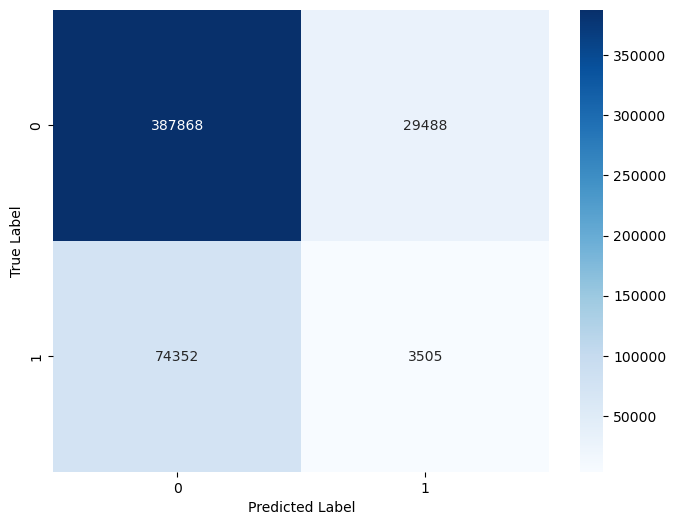

In [74]:
# Plot the confusion matrix for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Analysis Results

### Want to look at when in the sequence does a customer's bets change from 0 to 1. And how does accuracy change as more bets are considered.

In [75]:
#Predict for the test data and merge the predicted values with the original data
data_test=data.loc[best_test,:].copy()
y_pred = best_model.predict(X_test)
data_test['y_pred'] = y_pred

### Accuracy vs number of bets

In [76]:
# Create a column of 0 and 1 if correctly predicted
data_test['pred_correct']=(data_test['y_pred']==data_test['high_net_worth'])

#Group the data by total number of bets and for each number of bets compute accuracy
accgroup = data_test.groupby('total_bets_until_now')['pred_correct'].mean()
accgroup=accgroup.reset_index()

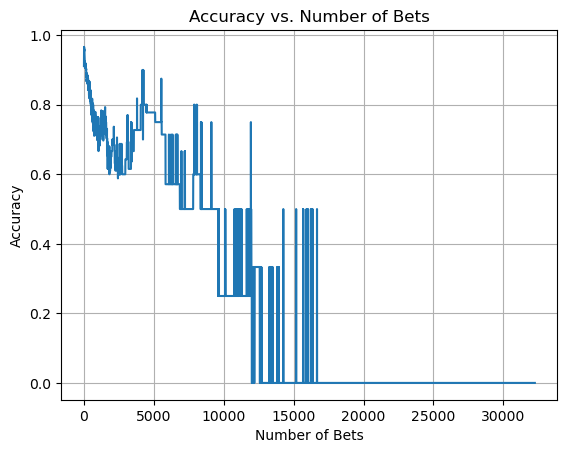

In [77]:
# Visualize accuracy against the number of bets
plt.plot(accgroup['total_bets_until_now'], accgroup['pred_correct'])
plt.xlabel('Number of Bets')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Bets')
plt.grid(True)
plt.show()

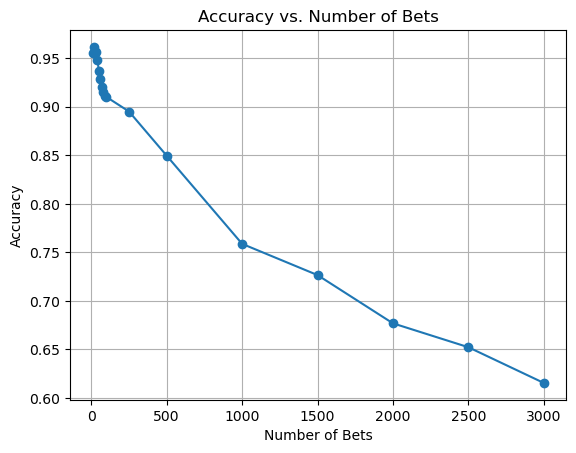

In [78]:
#Discretize the number of bets into bins and then visualize the 
#accuracy against the number of bets in each category

data_test['n_bets']=pd.cut(data_test['total_bets_until_now'],[0,10,20,30,40,50,60,70,80,90,100,250,500,1000,1500,2000,2500,3000],
                           labels=[10,20,30,40,50,60,70,80,90,100,250,500,1000,1500,2000,2500,3000])

accgroup2 = data_test.groupby('n_bets')['pred_correct'].mean()
accgroup2=accgroup2.reset_index()

# Visualize
plt.plot(accgroup2['n_bets'], accgroup2['pred_correct'],marker='o')
plt.xlabel('Number of Bets')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Bets')
#plt.xlim([0,100])
plt.grid(True)
plt.show()
                             

### Precision vs number of bets

In [79]:
# Create columns for True Positives (TP), False Positives (FP) and False Negatives (FN)
data_test['TP'] = ((data_test['y_pred'] == 1) & (data_test['high_net_worth'] == 1)).astype(int)
data_test['FP'] = ((data_test['y_pred'] == 1) & (data_test['high_net_worth'] == 0)).astype(int)
data_test['FN'] = ((data_test['y_pred'] == 0) & (data_test['high_net_worth'] == 1)).astype(int)

#Group the data by total number of bets and for each number of bets compute TP and FP
prec_group = data_test.groupby('total_bets_until_now').agg({'TP': 'sum', 'FP': 'sum'})
prec_group=prec_group.reset_index()

In [80]:
# Compute precision for each group
prec_group['Precision'] = prec_group['TP'] / (prec_group['TP'] + prec_group['FP'])

# Handle NaN/Inf values if any (e.g., when both TP and FP are zero)
prec_group['Precision'].replace({np.inf: 0, np.nan: 0}, inplace=True)

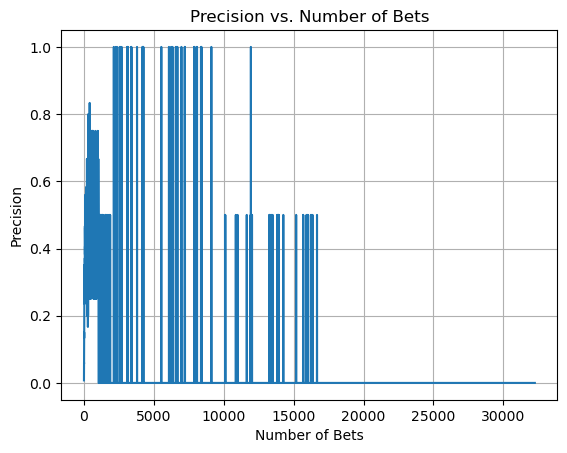

In [81]:
# Visualize precision against the number of bets
plt.plot(prec_group['total_bets_until_now'], prec_group['Precision'])
plt.xlabel('Number of Bets')
plt.ylabel('Precision')
plt.title('Precision vs. Number of Bets')
plt.grid(True)
plt.show()

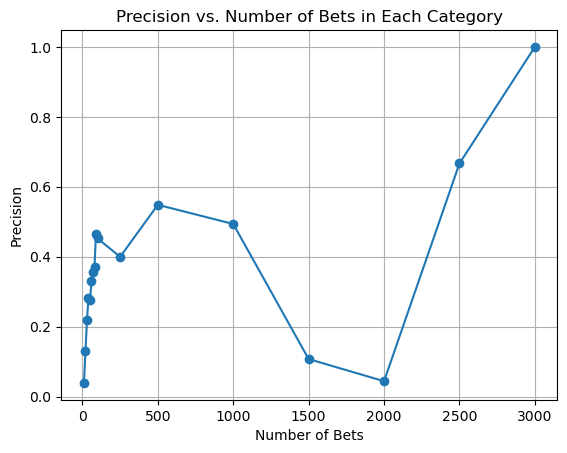

In [82]:
#Discretize the number of bets into bins and then visualize the 
#accuracy against the number of bets in each category

data_test['n_bets']=pd.cut(data_test['total_bets_until_now'],[0,10,20,30,40,50,60,70,80,90,100,250,500,1000,1500,2000,2500,3000],
                           labels=[10,20,30,40,50,60,70,80,90,100,250,500,1000,1500,2000,2500,3000])

# Group by number of bets category and compute precision
precision_group = data_test.groupby('n_bets').apply(lambda x: x['TP'].sum() / (x['TP'].sum() + x['FP'].sum())).reset_index()
precision_group.columns = ['n_bets', 'precision']

# Visualize
plt.plot(precision_group['n_bets'], precision_group['precision'], marker='o')
plt.xlabel('Number of Bets')
plt.ylabel('Precision')
plt.title('Precision vs. Number of Bets in Each Category')
plt.grid(True)
plt.show()                

### Recall vs number of bets

In [83]:
# Group by total number of bets and compute recall
recall_group = data_test.groupby('total_bets_until_now').apply(lambda x: x['TP'].sum() / (x['TP'].sum() + x['FN'].sum())).reset_index()
recall_group.columns = ['total_bets_until_now', 'recall']

invalid value encountered in long_scalars


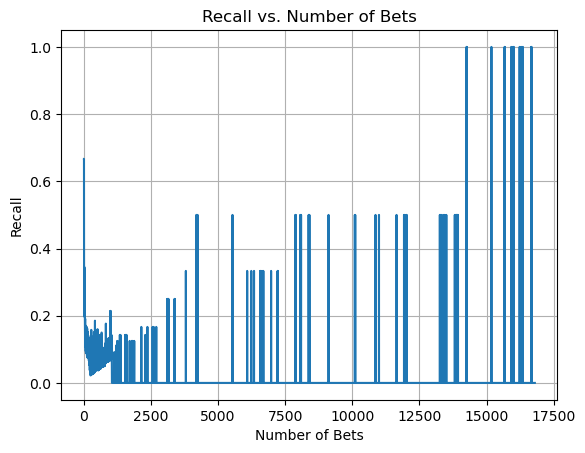

In [84]:
# Visualize recall against the number of bets
plt.plot(recall_group['total_bets_until_now'], recall_group['recall'])
plt.xlabel('Number of Bets')
plt.ylabel('Recall')
plt.title('Recall vs. Number of Bets')
plt.grid(True)
plt.show()

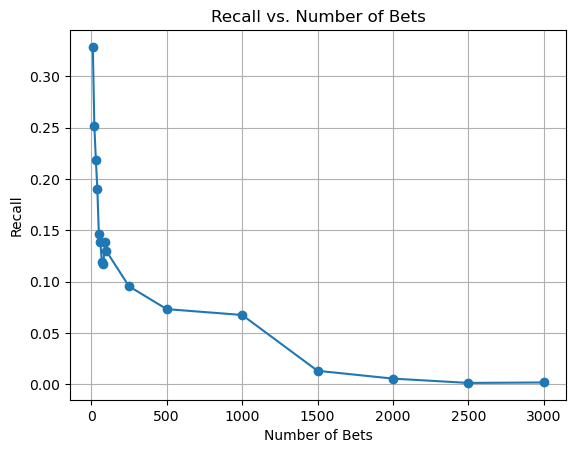

In [85]:
#Discretize the number of bets into bins and then visualize the 
#accuracy against the number of bets in each category

data_test['n_bets']=pd.cut(data_test['total_bets_until_now'],[0,10,20,30,40,50,60,70,80,90,100,250,500,1000,1500,2000,2500,3000],
                           labels=[10,20,30,40,50,60,70,80,90,100,250,500,1000,1500,2000,2500,3000])

# Group by the number of bets bin and compute recall for each bin
recall_group2 = data_test.groupby('n_bets').apply(lambda x: x['TP'].sum() / (x['TP'].sum() + x['FN'].sum())).reset_index()
recall_group2.columns = ['n_bets', 'recall']

# Visualize recall against the number of bets for each bin
plt.plot(recall_group2['n_bets'], recall_group2['recall'], marker='o')
plt.xlabel('Number of Bets')
plt.ylabel('Recall')
plt.title('Recall vs. Number of Bets')
plt.grid(True)
plt.show()
                             

### Proportion of HNW

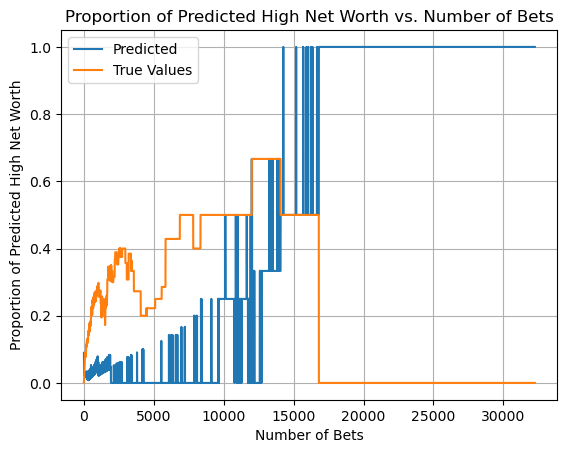

In [86]:
# create proportion of true and predicted high_net_worth for each number of bets and then visualize

predgroup = data_test.groupby('total_bets_until_now')[['high_net_worth','y_pred']].mean()
predgroup = predgroup.reset_index()

# Visualize
plt.plot(predgroup['total_bets_until_now'], predgroup['y_pred'],label='Predicted')
plt.plot(predgroup['total_bets_until_now'], predgroup['high_net_worth'],label='True Values')
plt.xlabel('Number of Bets')
plt.ylabel('Proportion of Predicted High Net Worth')
plt.title('Proportion of Predicted High Net Worth vs. Number of Bets')
plt.legend()
plt.grid(True)
plt.show()

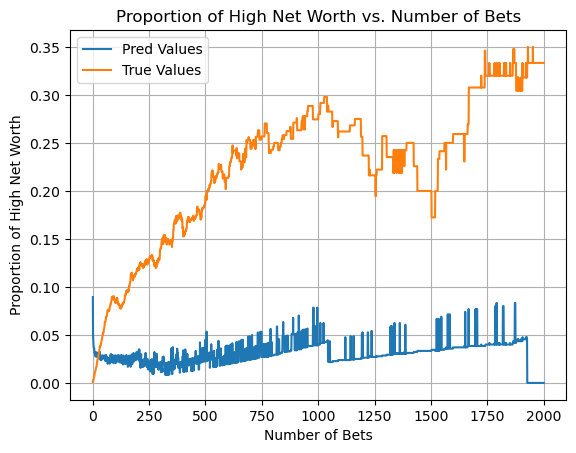

In [87]:
# Visualize the same as above when number of bets is upto 2000.
plt.plot(predgroup['total_bets_until_now'][:2000], predgroup['y_pred'][:2000], label='Pred Values')
plt.plot(predgroup['total_bets_until_now'][:2000], predgroup['high_net_worth'][:2000],label='True Values')
plt.xlabel('Number of Bets')
plt.ylabel('Proportion of High Net Worth')
plt.title('Proportion of High Net Worth vs. Number of Bets')
plt.legend()
plt.grid(True)
plt.show()

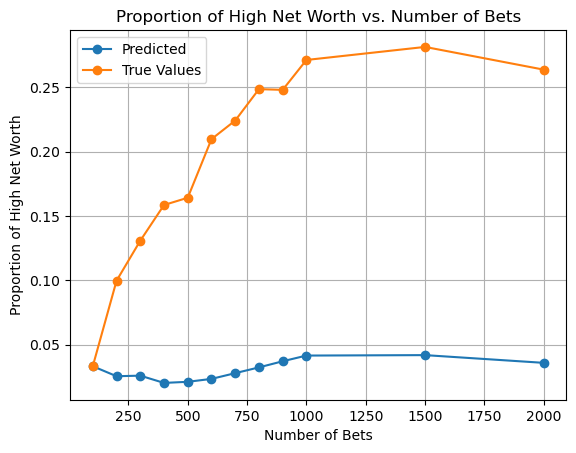

In [88]:
# create proportion of true and predicted high_net_worth for each number of bets and user and then visualize

data_test['n_bets']=pd.cut(data_test['total_bets_until_now'],[0,100,200,300,400,500,600,700,800,900,1000,1500,2000],
                           labels=[100,200,300,400,500,600,700,800,900,1000,1500,2000])
predgroup2 = data_test.groupby(['encrypted_user_no','n_bets'])[['high_net_worth','y_pred']].mean()
predgroup2 = predgroup2.reset_index()
predgroup3 = predgroup2.groupby(['n_bets'])[['high_net_worth','y_pred']].mean()
predgroup3 = predgroup3.reset_index()

# Visualize
#predgroup2.plot.bar('n_bets', ['high_net_worth','y_pred'])
plt.plot(predgroup3['n_bets'], predgroup3['y_pred'],marker='o',label='Predicted')
plt.plot(predgroup3['n_bets'], predgroup3['high_net_worth'],marker='o', label='True Values')
plt.xlabel('Number of Bets')
plt.ylabel('Proportion of High Net Worth')
plt.title('Proportion of High Net Worth vs. Number of Bets')
plt.legend()
plt.grid(True)
plt.show()

### Num bets before label change

In [89]:
#Bets before change for each user
data_test = data_test.sort_values(['encrypted_user_no','total_bets_until_now'])
data_test['y_diffs'] = data_test['high_net_worth'].diff()
data_test['ypred_diffs'] = data_test['y_pred'].diff()

mask = (data_test['encrypted_user_no'] != data_test['encrypted_user_no'].shift(1) )
data_test.loc[mask,'y_diffs'] = np.nan
data_test.loc[mask,'ypred_diffs'] = np.nan

bet_changey=data_test.index[np.where(data_test.y_diffs==1)[0]]
bet_changeyp=data_test.index[np.where(data_test.ypred_diffs==1)[0]]


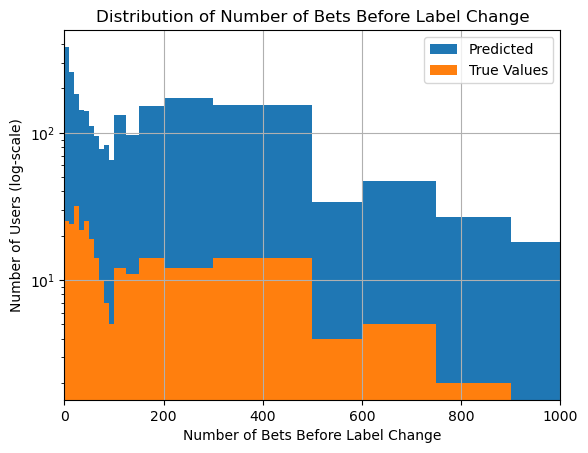

In [90]:
# Visualize
bins = [0,10,20,30,40,50,60,70,80,90,100,125, 150, 200,300,500,600,750,900,1000]
ax=data_test.loc[bet_changeyp,:].hist('total_bets_until_now',bins=bins,label='Predicted')
data_test.loc[bet_changey,:].hist('total_bets_until_now',bins=bins,ax=ax,label='True Values')

plt.xlim([0,1000])
# Labels and title
plt.yscale('log')
plt.xlabel('Number of Bets Before Label Change')
plt.ylabel('Number of Users (log-scale)')
plt.title('Distribution of Number of Bets Before Label Change')
plt.legend()
plt.grid(True)
plt.show()

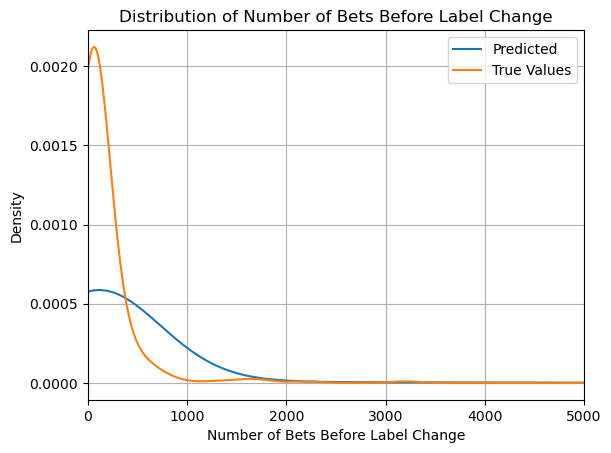

In [91]:
ax=data_test.loc[bet_changeyp,'total_bets_until_now'].plot.density(label='Predicted')
data_test.loc[bet_changey,'total_bets_until_now'].plot.density(ax=ax,label='True Values')

plt.xlim([0,5000])
plt.xlabel('Number of Bets Before Label Change')
plt.ylabel('Density')
plt.title('Distribution of Number of Bets Before Label Change')
plt.legend()
plt.grid(True)
plt.show()

## Feature Importance using SHAP

Traditional HMMs are generative probabilistic models and they don't intrinsically provide feature importance in the same way that tree-based models or linear models do.

However, we can follow a pseudo-feature-importance approach similar to permutation importance. Here's how it works:

Compute the accuracy (or other desired metrics) of the trained model using the test set.
For each feature, shuffle its values and then compute the model's accuracy with this permuted data.
The difference between the original accuracy and the permuted accuracy provides a measure of the importance of that feature.

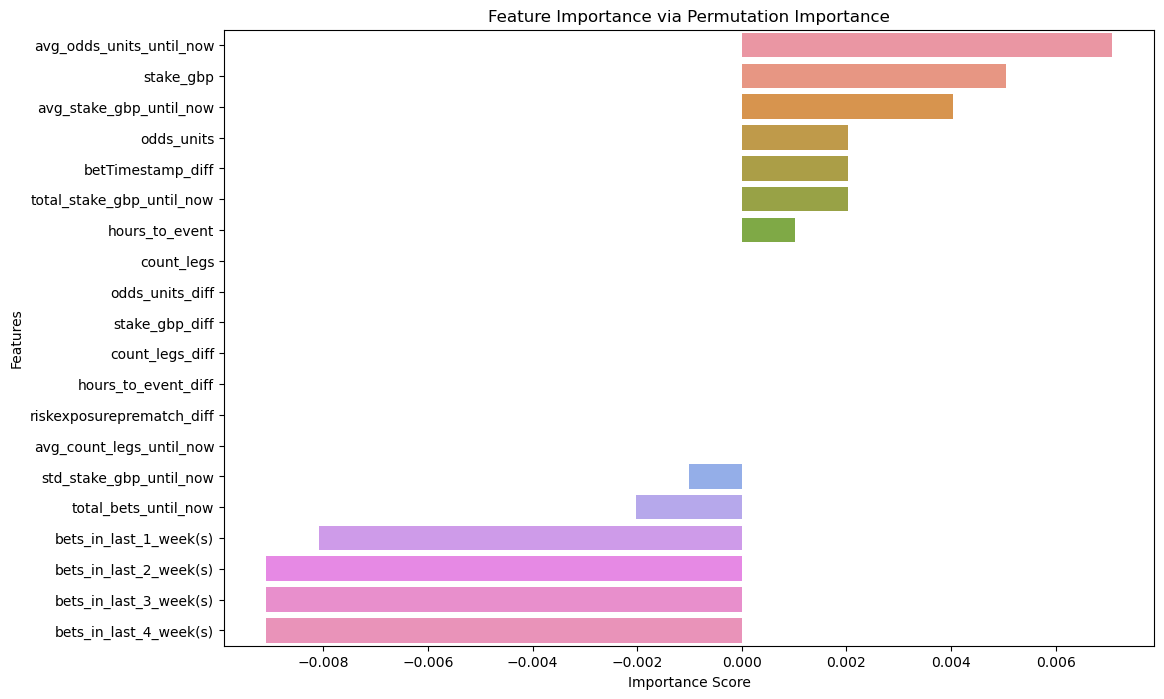

In [92]:
def compute_permutation_importance(model, X, y, metric=accuracy_score):
    """
    Compute permutation importance for each feature in X.
    
    Parameters:
        model: the trained model.
        X: the data (numpy array).
        y: the true labels.
        metric: a callable to compute a metric between true and predicted labels. 
        
    Returns:
        feature_importances: a dict mapping feature names to their importance scores.
    """
    
    # 1. Compute the original metric
    original_score = metric(y, model.predict(X))
    
    # 2. Compute score for each permuted feature
    permuted_scores = {}
    for i, feature_name in enumerate(features):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, i])
        permuted_score = metric(y, model.predict(X_permuted))
        permuted_scores[feature_name] = original_score - permuted_score
    
    return permuted_scores

# Sample on 20% of the test set - roughly 1000 datapoints
sample_fraction = 0.002
sample_size = int(len(X_test) * sample_fraction)

# Sample indices
sample_indices = np.random.choice(len(X_test), size=sample_size, replace=False)

# Extract the samples
X_sample = X_test[sample_indices]
y_sample = y_test[sample_indices]

# Now compute the permutation importance on this sample
importance_scores = compute_permutation_importance(best_model, X_sample, y_sample)

# Visualizing feature importances
sorted_importance = dict(sorted(importance_scores.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(12, 8))
sns.barplot(x=list(sorted_importance.values()), y=list(sorted_importance.keys()))
plt.title('Feature Importance via Permutation Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()